In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'}

titles=[]
overall_ratings=[]
placement_ratings=[]
infra_ratings=[]
no_of_reviews=[]
fees=[]
salaries=[]
nirf_ranks=[]
streams = []

In [56]:
def scrape_colleges(base_url,stream,n=10):
    for i in range(1,n+1):
        url = f"{base_url}?pageNo={i}"
        page = requests.get(url, headers=headers, timeout=30)

        soup = BeautifulSoup(page.text, 'html.parser')
        colleges = soup.find_all('section', class_='rank_tuplev1')

        for college in colleges:
            #Title
            title = college.find('h4', class_='f14_bold link')
            titles.append(title.text.strip() if title else np.nan)

            #Ratings
            rating = college.find('span', class_='rating-block rvw-lyr')
            if rating:
                txt = rating.text.strip()
                overall = re.search(r'^(\d\.\d)', txt)
                placements = re.search(r'Placements(\d\.\d)', txt)
                infra = re.search(r'Infrastructure(\d\.\d)', txt)
                reviews = re.search(r'(\d+)\s+reviews', txt)

                overall_ratings.append(overall.group(1) if overall else np.nan)
                placement_ratings.append(placements.group(1) if placements else np.nan)
                infra_ratings.append(infra.group(1) if infra else np.nan)
                no_of_reviews.append(reviews.group(1) if reviews else np.nan)
            else:
                overall_ratings.append(np.nan)
                placement_ratings.append(np.nan)
                infra_ratings.append(np.nan)
                no_of_reviews.append(np.nan)

            #Fees & Salary
            fee_val, sal_val = np.nan, np.nan
            fee_salary_blocks = college.find_all('div', class_='flex_v text--secondary')
            for block in fee_salary_blocks:
                txt = block.text.replace('\xa0', ' ').strip()
                fee_match = re.search(r'Fees.*?₹\s*([\d]+\.?\d*)\s*Lakh', txt)
                sal_match = re.search(r'Salary\s*:\s*₹\s*([\d]+\.?\d*)\s*Lakh', txt)
                if fee_match:
                    fee_val = fee_match.group(1)
                if sal_match:
                    sal_val = sal_match.group(1)

            fees.append(fee_val)
            salaries.append(sal_val)

            #Rank
            rank_val = np.nan
            rank_span = college.find('span', class_='circleText')
            if rank_span:
                rank_val = rank_span.text.strip()
            nirf_ranks.append(rank_val)

            # Stream
            streams.append(stream)

In [57]:
#Engineering
scrape_colleges("https://www.shiksha.com/engineering/ranking/top-engineering-colleges-in-india/44-2-0-0-0", "Engineering")

#Medical
scrape_colleges("https://www.shiksha.com/medicine-health-sciences/ranking/top-medical-colleges-in-india/109-2-0-0-0", "Medical")

#MBA
scrape_colleges("https://www.shiksha.com/mba/ranking/top-mba-colleges-in-india/2-2-0-0-0", "MBA")

In [58]:
df = pd.DataFrame({
    'NIRF Rank': nirf_ranks,
    'College': titles,
    'Stream': streams,
    'Overall Rating': overall_ratings,
    'Placement Rating': placement_ratings,
    'Infra Rating': infra_ratings,
    'Reviews': no_of_reviews,
    'Fees (Lakh)': fees,
    'Salary (Lakh)': salaries
})

In [16]:
df=df.astype(object)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1139 entries, 0 to 1138
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   NIRF Rank         1139 non-null   object 
 1   College           1139 non-null   object 
 2   Stream            1139 non-null   object 
 3   Overall Rating    1139 non-null   float64
 4   Placement Rating  1139 non-null   float64
 5   Infra Rating      1139 non-null   float64
 6   Reviews           1139 non-null   int64  
 7   Fees (Lakh)       1050 non-null   float64
 8   Salary (Lakh)     711 non-null    float64
dtypes: float64(5), int64(1), object(3)
memory usage: 80.2+ KB


In [ ]:
df.to_csv("uncleaned_colleges_dataset.csv", index=False)

In [21]:
df = pd.read_csv('uncleaned_colleges_dataset.csv')

In [22]:
df_unique = df.drop_duplicates(subset=['College', 'Stream'], keep='first').reset_index(drop=True)

In [23]:
print("Before dedup:", df.shape)
print("After dedup:", df_unique.shape)
print(df_unique['Stream'].value_counts())

Before dedup: (1139, 9)
After dedup: (419, 9)
Stream
Engineering    283
MBA             96
Medical         40
Name: count, dtype: int64


In [24]:
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   NIRF Rank         419 non-null    object 
 1   College           419 non-null    object 
 2   Stream            419 non-null    object 
 3   Overall Rating    419 non-null    float64
 4   Placement Rating  419 non-null    float64
 5   Infra Rating      419 non-null    float64
 6   Reviews           419 non-null    int64  
 7   Fees (Lakh)       377 non-null    float64
 8   Salary (Lakh)     264 non-null    float64
dtypes: float64(5), int64(1), object(3)
memory usage: 29.6+ KB


In [25]:
df_unique.isna().sum()

NIRF Rank             0
College               0
Stream                0
Overall Rating        0
Placement Rating      0
Infra Rating          0
Reviews               0
Fees (Lakh)          42
Salary (Lakh)       155
dtype: int64

In [26]:
df.head(3)

,NIRF Rank,College,Stream,Overall Rating,Placement Rating,Infra Rating,Reviews,Fees (Lakh),Salary (Lakh)
0,1,IIT Madras - Indian Institute of Technology,Engineering,4.5,4.4,4.5,349,10.0,19.00
1,2,IIT Delhi - Indian Institute of Technology,Engineering,4.5,4.4,4.4,631,8.0,19.08
2,3,IIT Bombay - Indian Institute of Technology,Engineering,4.6,4.6,4.5,445,8.0,17.92


In [27]:
df_unique['Fees (Lakh)'] = (df_unique['Fees (Lakh)'].astype(str).str.replace(r'[^\d\.]', '', regex=True).replace('', np.nan).astype(float))

In [28]:
df_unique['Salary (Lakh)'] = (df_unique['Salary (Lakh)'].astype(str).str.replace(r'[^\d\.]', '', regex=True).replace('', np.nan).astype(float))

In [29]:
df_unique['Reviews'] = (df_unique['Reviews'].astype(str).str.extract(r'(\d+)').astype(int))

In [30]:
df_unique['NIRF Rank Clean'] = (df_unique['NIRF Rank'].astype(str).str.extract(r'(\d+)').astype(int))

In [31]:
for col in ['Overall Rating', 'Placement Rating', 'Infra Rating']:
    df_unique[col] = pd.to_numeric(df_unique[col], errors='coerce')

In [32]:
df_unique['Fees (Lakh)'] = df_unique.groupby('Stream')['Fees (Lakh)'].transform(lambda x: x.fillna(x.median()))

In [33]:
df_unique['Salary (Lakh)'] = df_unique.groupby('Stream')['Salary (Lakh)'].transform(lambda x: x.fillna(x.median()))

In [34]:
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   NIRF Rank         419 non-null    object 
 1   College           419 non-null    object 
 2   Stream            419 non-null    object 
 3   Overall Rating    419 non-null    float64
 4   Placement Rating  419 non-null    float64
 5   Infra Rating      419 non-null    float64
 6   Reviews           419 non-null    int32  
 7   Fees (Lakh)       419 non-null    float64
 8   Salary (Lakh)     419 non-null    float64
 9   NIRF Rank Clean   419 non-null    int32  
dtypes: float64(5), int32(2), object(3)
memory usage: 29.6+ KB


In [35]:
df_unique.to_csv('Cleaned_dataset.csv',index=False)

### Section 1: Understanding the Landscape (General Overview)

In [36]:
# Color palette
custom_palette = ["#E3966D", "#7FB77E", "#A97155", "#E6B8A2"]

# Set theme
sns.set(
    style="whitegrid", 
    palette=custom_palette, 
    font_scale=1.1
)

# Optional: Match background to PPT beige tone
plt.rcParams['figure.facecolor'] = '#F5E6DA'
plt.rcParams['axes.facecolor']   = '#FFFFFF'
plt.rcParams['savefig.facecolor'] = '#F5E6DA'

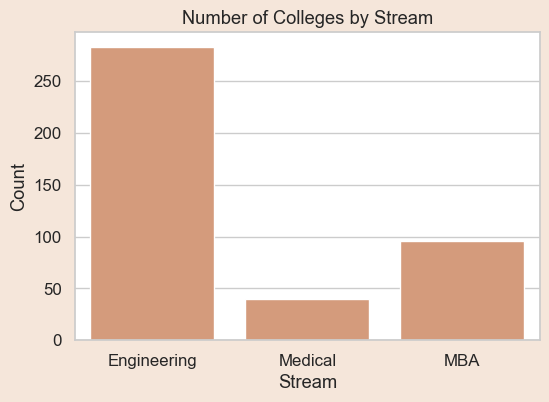

In [38]:
# 1. Count of Colleges by Stream
plt.figure(figsize=(6,4))
sns.countplot(x="Stream", data=df_unique)
plt.title("Number of Colleges by Stream")
plt.xlabel("Stream")
plt.ylabel("Count")
plt.show()


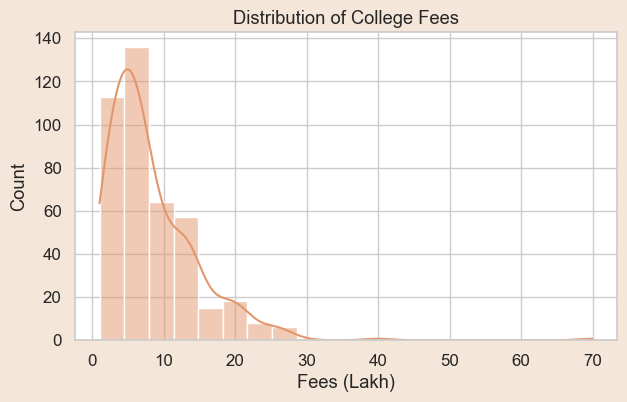

In [39]:

# 2. Distribution of Fees
plt.figure(figsize=(7,4))
sns.histplot(df_unique["Fees (Lakh)"], bins=20, kde=True)
plt.title("Distribution of College Fees")
plt.xlabel("Fees (Lakh)")
plt.ylabel("Count")
plt.show()


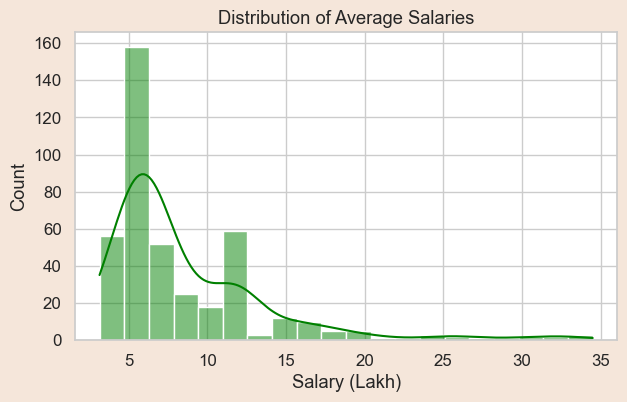

In [40]:

# 3. Distribution of Salaries
plt.figure(figsize=(7,4))
sns.histplot(df_unique["Salary (Lakh)"], bins=20, kde=True, color="green")
plt.title("Distribution of Average Salaries")
plt.xlabel("Salary (Lakh)")
plt.ylabel("Count")
plt.show()


### Section 2: Comparing Streams (Cost vs Return)

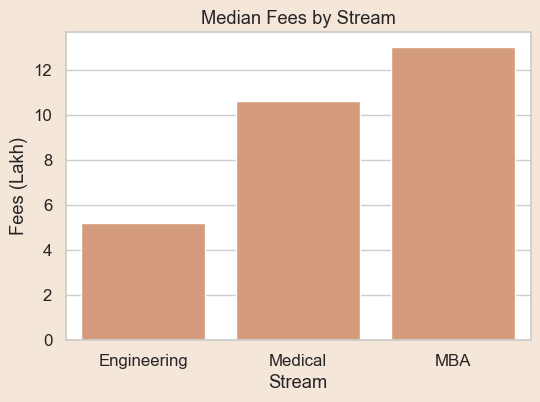

In [41]:

# 4. Average Fees by Stream
plt.figure(figsize=(6,4))
sns.barplot(x="Stream", y="Fees (Lakh)", data=df_unique, estimator="median", errorbar=None)
plt.title("Median Fees by Stream")
plt.ylabel("Fees (Lakh)")
plt.show()


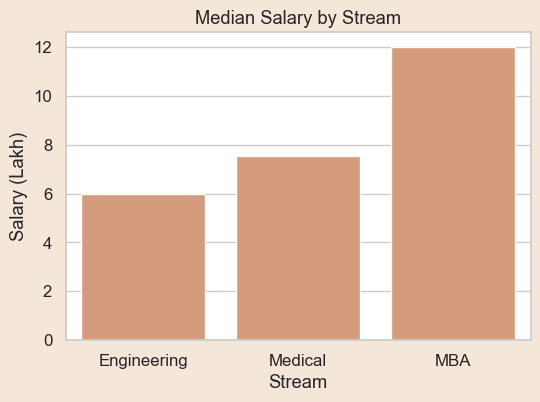

In [42]:

# 5. Average Salary by Stream
plt.figure(figsize=(6,4))
sns.barplot(x="Stream", y="Salary (Lakh)", data=df_unique, estimator="median", errorbar=None)
plt.title("Median Salary by Stream")
plt.ylabel("Salary (Lakh)")
plt.show()


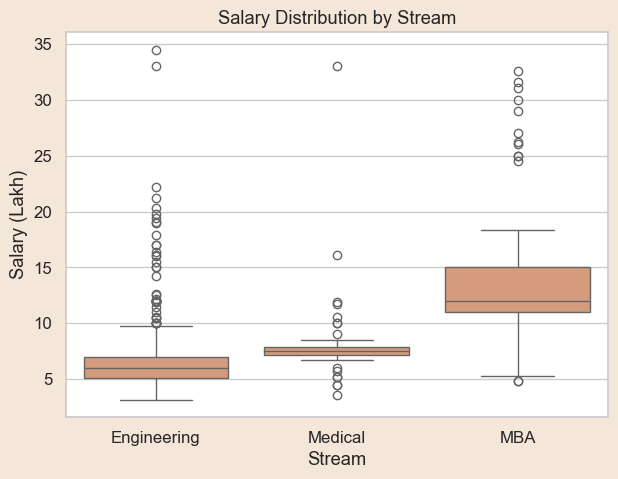

In [43]:
#6. Salary Distribution by Stream (Boxplot)
plt.figure(figsize=(7,5))
sns.boxplot(x="Stream", y="Salary (Lakh)", data=df_unique)
plt.title("Salary Distribution by Stream")
plt.ylabel("Salary (Lakh)")
plt.show()


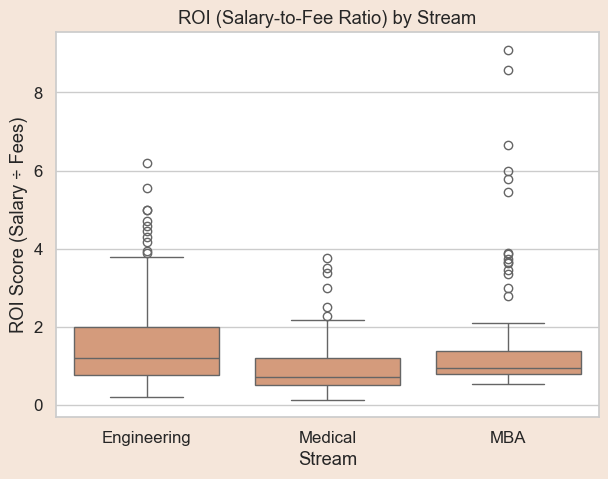

In [44]:

# 7. ROI Score (Salary / Fees)
df_unique["ROI Score"] = df_unique["Salary (Lakh)"] / df_unique["Fees (Lakh)"]
plt.figure(figsize=(7,5))
sns.boxplot(x="Stream", y="ROI Score", data=df_unique)
plt.title("ROI (Salary-to-Fee Ratio) by Stream")
plt.ylabel("ROI Score (Salary ÷ Fees)")
plt.show()


### Section 3: College Rankings & Outcomes

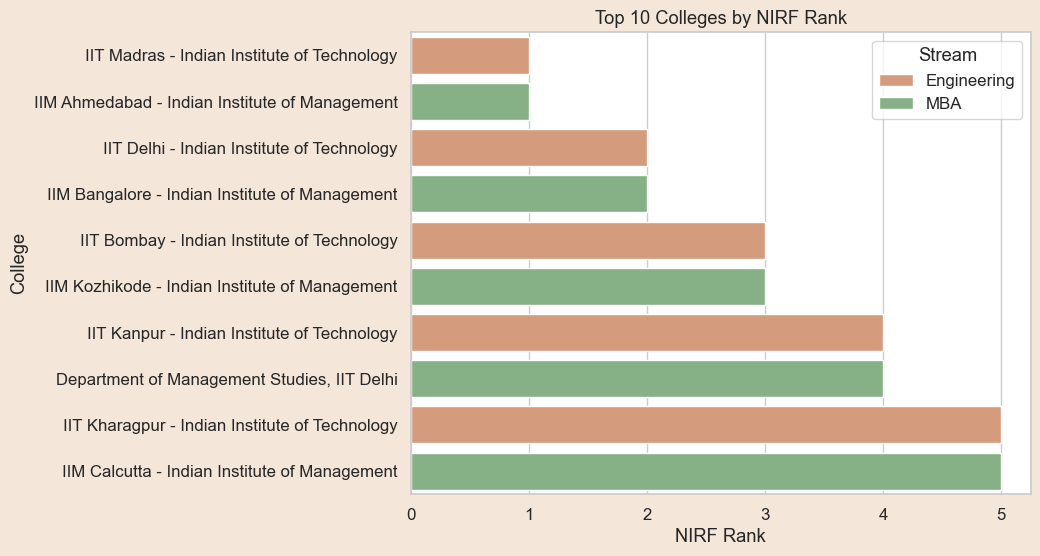

In [45]:

# 8. Top 10 Colleges by NIRF Rank
top10 = df_unique.nsmallest(10, "NIRF Rank Clean")
plt.figure(figsize=(8,6))
sns.barplot(y="College", x="NIRF Rank Clean", data=top10, hue="Stream")
plt.title("Top 10 Colleges by NIRF Rank")
plt.xlabel("NIRF Rank")
plt.ylabel("College")
plt.show()


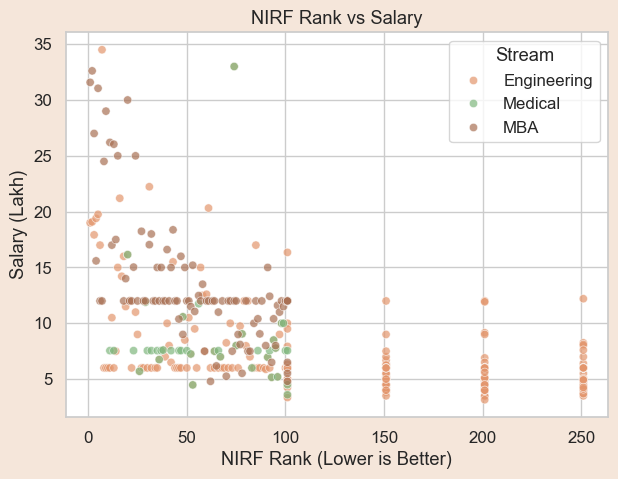

In [46]:
# 9. NIRF Rank vs Salary (Scatter)
plt.figure(figsize=(7,5))
sns.scatterplot(x="NIRF Rank Clean", y="Salary (Lakh)", hue="Stream", data=df_unique, alpha=0.7)
plt.title("NIRF Rank vs Salary")
plt.xlabel("NIRF Rank (Lower is Better)")
plt.ylabel("Salary (Lakh)")
plt.show()


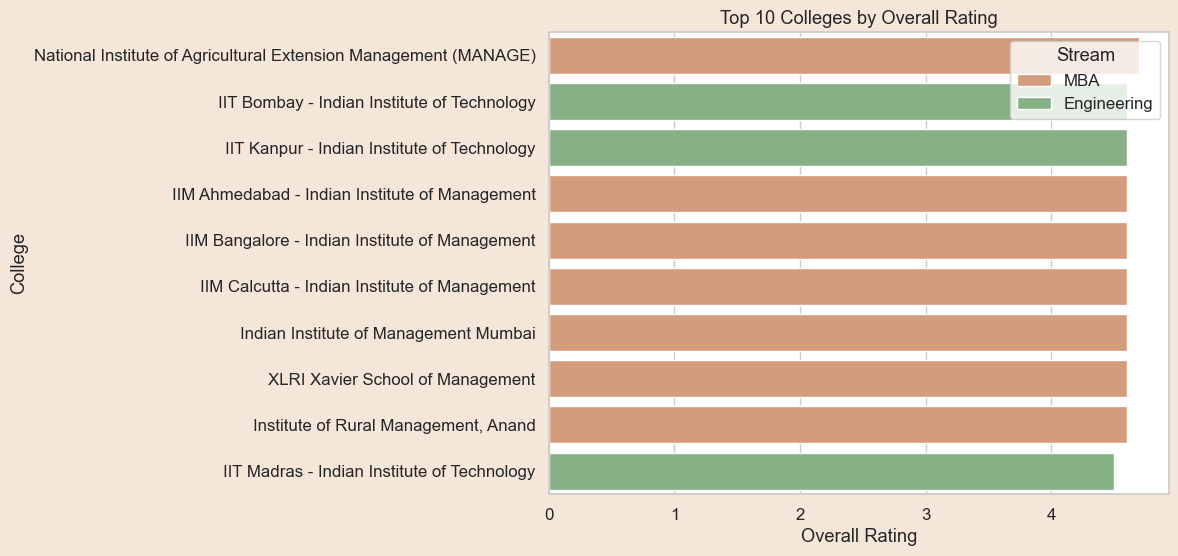

In [47]:
# 10. Top 10 Colleges by Overall Rating
top10_rating = df_unique.nlargest(10, "Overall Rating")
plt.figure(figsize=(8,6))
sns.barplot(y="College", x="Overall Rating", data=top10_rating, hue="Stream")
plt.title("Top 10 Colleges by Overall Rating")
plt.xlabel("Overall Rating")
plt.ylabel("College")
plt.show()


### Section 4: ROI and Decision-Making Insights (Student-Centric)

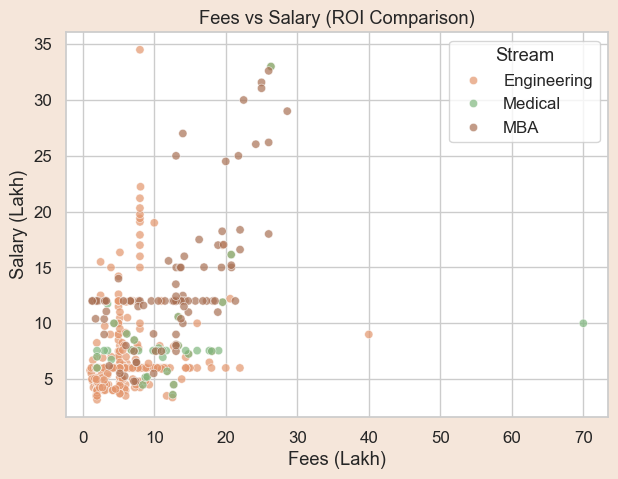

In [48]:

# 11. Fees vs Salary Scatter (ROI)
plt.figure(figsize=(7,5))
sns.scatterplot(x="Fees (Lakh)", y="Salary (Lakh)", hue="Stream", data=df_unique, alpha=0.7)
plt.title("Fees vs Salary (ROI Comparison)")
plt.xlabel("Fees (Lakh)")
plt.ylabel("Salary (Lakh)")
plt.show()


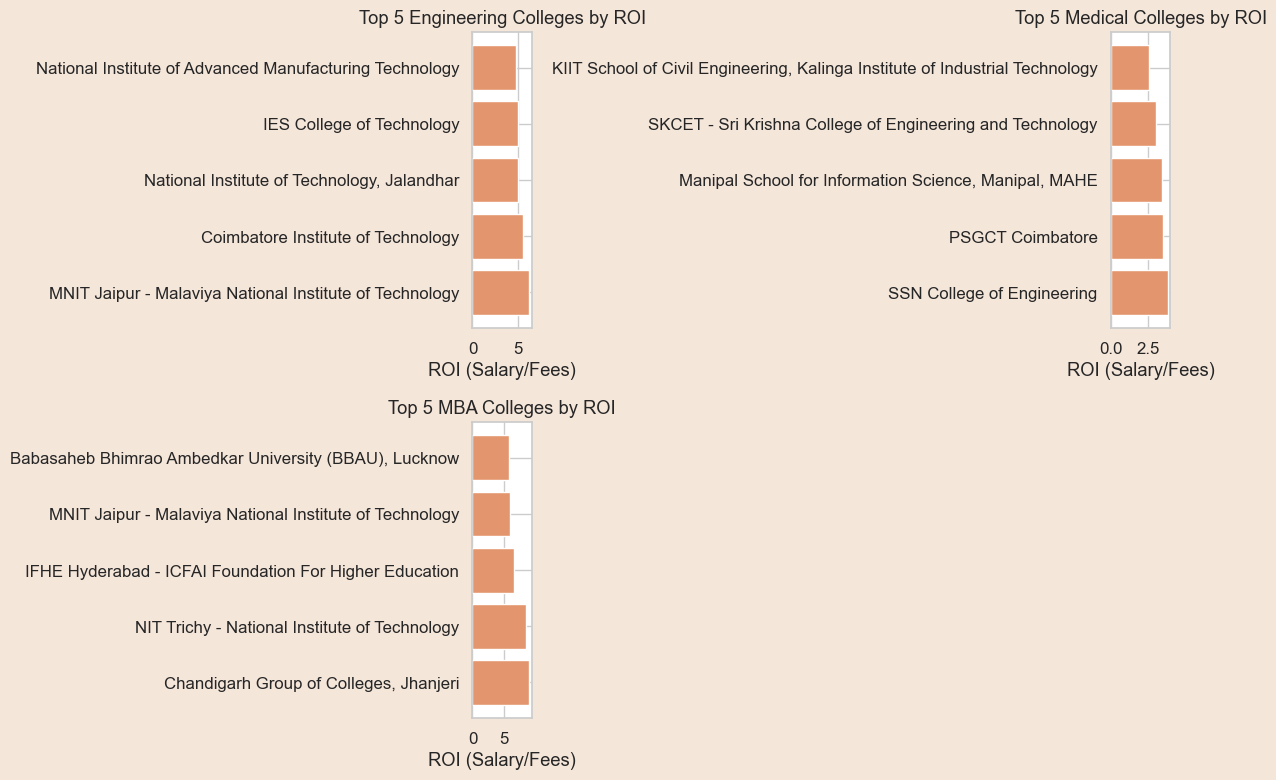

In [49]:
# 12. Top 5 Colleges by Stream based on ROI (Salary/Fees)
plt.figure(figsize=(12, 8))
df_roi = df_unique.copy()
df_roi['ROI'] = df_roi['Salary (Lakh)'] / df_roi['Fees (Lakh)']

for i, stream in enumerate(df_roi['Stream'].unique(), 1):
    plt.subplot(2, 2, i)
    stream_data = df_roi[df_roi['Stream'] == stream]
    top5 = stream_data.nlargest(5, 'ROI')
    plt.barh(top5['College'], top5['ROI'])
    plt.xlabel('ROI (Salary/Fees)')
    plt.title(f'Top 5 {stream} Colleges by ROI')
plt.tight_layout()
plt.show()

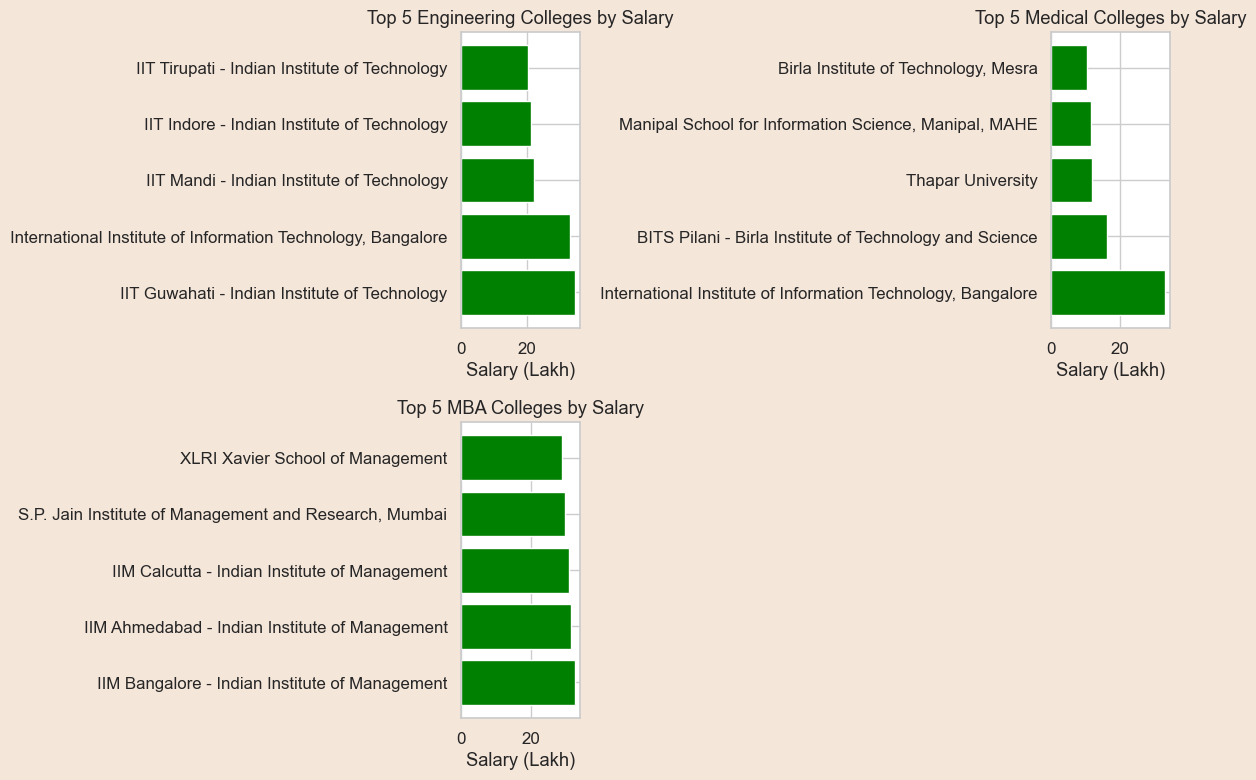

In [50]:
#13. Top 5 Colleges by Stream (Salary)
plt.figure(figsize=(12, 8))
for i, stream in enumerate(df_unique['Stream'].unique(), 1):
    plt.subplot(2, 2, i)
    stream_data = df_unique[df_unique['Stream'] == stream]
    top5 = stream_data.nlargest(5, 'Salary (Lakh)')
    plt.barh(top5['College'], top5['Salary (Lakh)'], color="green")
    plt.xlabel("Salary (Lakh)")
    plt.title(f"Top 5 {stream} Colleges by Salary")
plt.tight_layout()
plt.show()


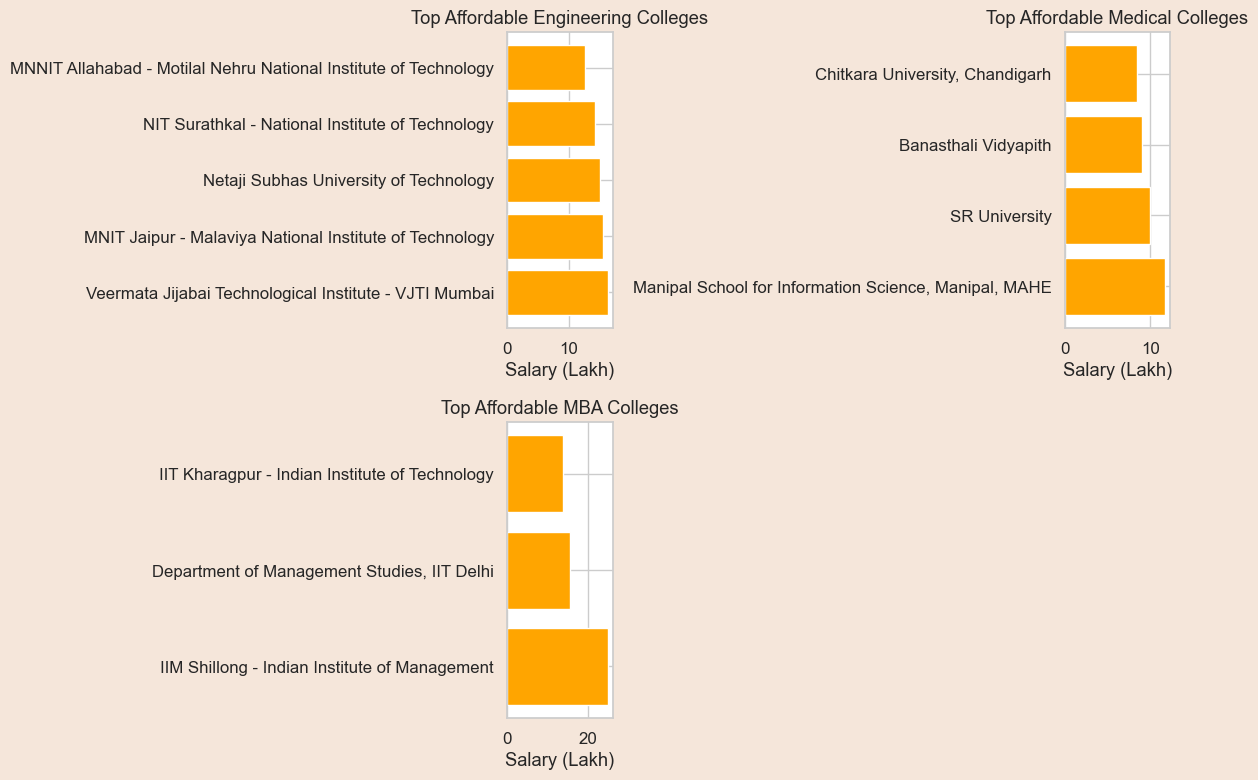

In [51]:
#14. Top 5 Affordable Colleges by Stream (Low Fees, Good Salary)
plt.figure(figsize=(12, 8))
for i, stream in enumerate(df_unique['Stream'].unique(), 1):
    plt.subplot(2, 2, i)
    stream_data = df_unique[df_unique['Stream'] == stream]
    affordable = stream_data[(stream_data['Fees (Lakh)'] <= stream_data['Fees (Lakh)'].median()) &
                            (stream_data['Salary (Lakh)'] >= stream_data['Salary (Lakh)'].mean())]
    top5 = affordable.nlargest(5, 'Salary (Lakh)')
    plt.barh(top5['College'], top5['Salary (Lakh)'], color="orange")
    plt.xlabel("Salary (Lakh)")
    plt.title(f"Top Affordable {stream} Colleges")
plt.tight_layout()
plt.show()


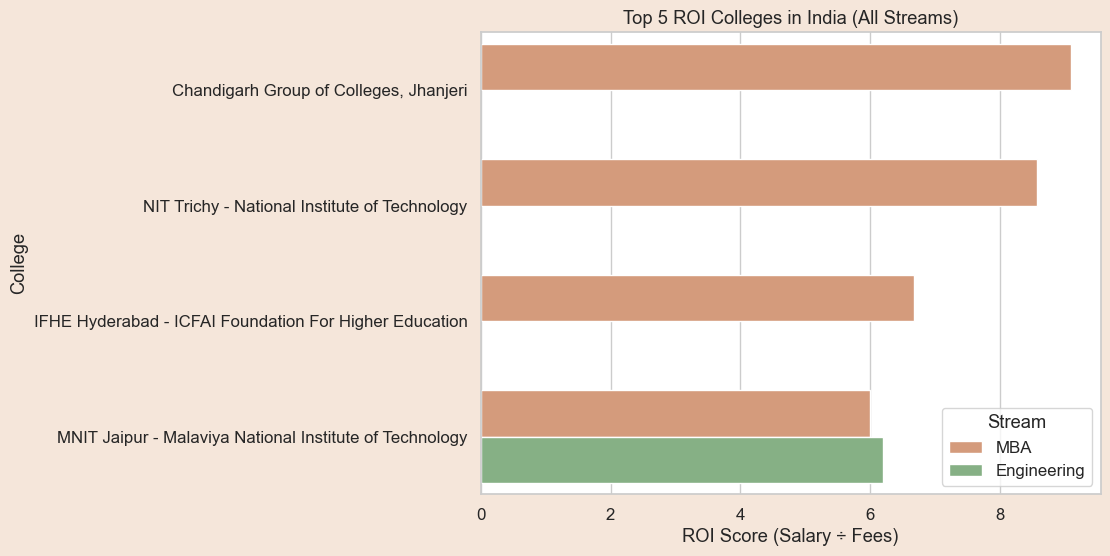

In [52]:
#15. Top 5 ROI Colleges in India (All Streams Combined)
top5_roi = df_unique.nlargest(5, "ROI Score")
plt.figure(figsize=(8,6))
sns.barplot(y="College", x="ROI Score", data=top5_roi, hue="Stream")
plt.title("Top 5 ROI Colleges in India (All Streams)")
plt.xlabel("ROI Score (Salary ÷ Fees)")
plt.ylabel("College")
plt.show()


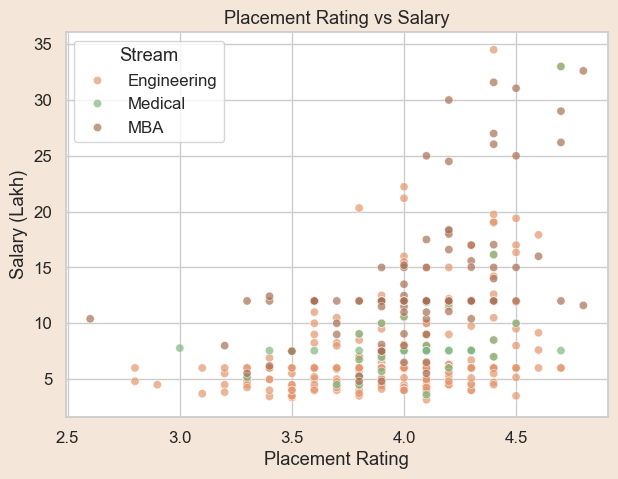

In [53]:
#16. Placement Rating vs Salary (Scatter)
plt.figure(figsize=(7,5))
sns.scatterplot(x="Placement Rating", y="Salary (Lakh)", hue="Stream", data=df_unique, alpha=0.7)
plt.title("Placement Rating vs Salary")
plt.xlabel("Placement Rating")
plt.ylabel("Salary (Lakh)")
plt.show()


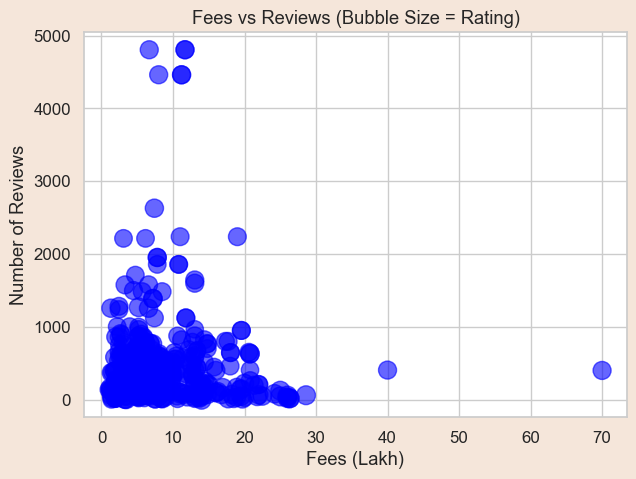

In [54]:
#17. Fees vs Reviews (Bubble Plot)
plt.figure(figsize=(7,5))
plt.scatter(df_unique["Fees (Lakh)"], df_unique["Reviews"], 
            s=df_unique["Overall Rating"]*40, alpha=0.6, c="blue")
plt.title("Fees vs Reviews (Bubble Size = Rating)")
plt.xlabel("Fees (Lakh)")
plt.ylabel("Number of Reviews")
plt.show()
